In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
# Tz
class MonotonicLinear(torch.nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size  = input_size
    self.output_size = output_size
    self.weights = torch.nn.Parameter(torch.rand((output_size, input_size), dtype=torch.float32))

  def forward(self, x):
    z = torch.mm(x, torch.exp(self.weights.t()))
    return z

class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input1 = MonotonicLinear(1, 3)
    self.input2 = torch.nn.Linear(2, 3)
    self.output = torch.nn.MaxPool1d(3)

  def forward(self, x_m, x_u):
    z1 = self.input1(x_m)
    z2 = self.input2(x_u)
    z = torch.add(z1, z2)
    z = self.output(z)
    return z

Tz = Net()
Tz = torch.load('C:/Users/tln229/Downloads/Python/Building/0. Saved models/Tz.pt')

In [3]:
# Thermostat
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input   = torch.nn.Linear(3, 32)
        self.output  = torch.nn.Linear(32, 1)

    def forward(self, x):
        z = torch.tanh(self.input(x))
        z = self.output(z)
        z = torch.relu(100 - torch.relu(z))
        return z

Thermostat = Net()
Thermostat = torch.load('C:/Users/tln229/Downloads/Python/Building/0. Saved models/Thermostat.pt')

In [4]:
# Tsa
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input1  = MonotonicLinear(2, 32)
    self.hidden1 = MonotonicLinear(32, 1)
    self.input2  = torch.nn.Linear(2, 32)
    self.hidden2 = torch.nn.Linear(32, 1)

  def forward(self, x_m, x_u):
    z1 = torch.tanh(self.input1(x_m))
    z1 = self.hidden1(z1)

    z2 = torch.tanh(self.input2(x_u))
    z2 = self.hidden2(z2)

    z = torch.add(z1, z2)
    return z

Tsa = Net()
Tsa = torch.load('C:/Users/tln229/Downloads/Python/Building/0. Saved models/Tsa.pt')

In [5]:
# msa
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input   = torch.nn.Linear(4, 32)
    self.output  = torch.nn.Linear(32, 1)

  def forward(self, x):
    z = torch.selu(self.input(x))
    z = self.output(z)
    return z

msa = Net()
msa = torch.load('C:/Users/tln229/Downloads/Python/Building/0. Saved models/msa.pt')

In [6]:
# qrh
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input   = torch.nn.Linear(4, 32)
    self.output  = torch.nn.Linear(32, 1)

  def forward(self, x):
    z = torch.selu(self.input(x))
    z = self.output(z)
    return z

qrh = Net()
qrh = torch.load('C:/Users/tln229/Downloads/Python/Building/0. Saved models/qrh.pt')

In [7]:
# Read data
df = pd.read_csv('C:/Users/tln229/Downloads/Python/Building/data/HVAC_B90_102_exp_10m_20210424.csv')

# LEAST SQUARE
ones = np.ones(np.array(df['airflow_desired']).reshape(-1,1).shape)
A = np.concatenate((np.array(df['htg_valve_command']).reshape(-1,1), ones), axis=1)
b = np.copy(np.array(df['airflow_desired']).reshape(-1,1))
p = np.linalg.lstsq(A, b, rcond=None)[0]

def LQ(q):
    return q*p[0] + p[1]

In [8]:
start = 64
end   = 1600

msa_0 = np.array(df['airflow_current']).reshape(-1,1)[start: end]
msa_1 = np.array(df['airflow_current']).reshape(-1,1)[start+1: end+1]
msa_2 = np.array(df['airflow_current']).reshape(-1,1)[start+2: end+2]

qrh_0 = np.array(df['htg_valve_position']).reshape(-1,1)[start: end]
qrh_1 = np.array(df['htg_valve_position']).reshape(-1,1)[start+1: end+1]
qrh_2 = np.array(df['htg_valve_position']).reshape(-1,1)[start+2: end+2]
qc_2  = np.array(df['htg_valve_command']).reshape(-1,1)[start+2: end+2]

Tca_2 = np.array(df['ahu_supply_temp']).reshape(-1,1)[start+2: end+2]

Tsa_1 = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+1: end+1]
Tsa_2 = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+2: end+2]

Tz_2  = np.array(df['room_temp']).reshape(-1,1)[start+2: end+2]
Tz_3  = np.array(df['room_temp']).reshape(-1,1)[start+3: end+3]

clg_sp       = np.array(df['clg_sp_current']).reshape(-1,1)[start+2: end+2]
htg_sp       = np.array(df['htg_sp_current']).reshape(-1,1)[start+2: end+2]
htg_clg_mode = 1*np.array(df['htg_clg_mode']).reshape(-1,1)[start+2: end+2]
Tsp_2        = htg_sp*htg_clg_mode + clg_sp*(1-htg_clg_mode)

In [9]:
def NormalizeData(data, min, max):
    return 100*(data-min)/(max-min)

def DeNormalizeData(scaled_data, min, max):
    return min + scaled_data*(max-min)/100

In [10]:
with torch.no_grad():
    x = np.concatenate((Tsp_2, Tz_2, qc_2), axis=1)
    x = torch.tensor(x, dtype=torch.float32)
    qc_3 = Thermostat(x)

    x = np.concatenate((qc_3, qrh_0, qrh_1, qrh_2), axis=1)
    x = torch.tensor(x, dtype=torch.float32)
    qrh_3 = qrh(x)
    qrh_3 = torch.relu(qrh_3) - torch.relu(qrh_3 - 100)

    mc_3 = LQ(qc_3)
    x = np.concatenate((mc_3, msa_0, msa_1, msa_2), axis=1)
    x = NormalizeData(x, 400, 1000)
    x = torch.tensor(x, dtype=torch.float32)
    msa_3 = msa(x)
    msa_3 = torch.relu(msa_3) - torch.relu(msa_3 - 100)
    msa_3 = DeNormalizeData(msa_3, 400, 1000)

    x1 = np.concatenate((Tca_2, qrh_3), axis=1)
    x1 = torch.tensor(x1, dtype=torch.float32)
    x2 = np.concatenate((Tsa_1, Tsa_2), axis=1)
    x2 = torch.tensor(x2, dtype=torch.float32)
    Tsa_3 = Tsa(x1, x2)

    x1 = torch.tensor(np.copy(Tsa_3), dtype=torch.float32)
    x2 = np.concatenate((Tz_2, msa_3), axis=1)
    x2 = torch.tensor(x2, dtype=torch.float32)
    Tz_3_t = Tz(x1, x2)

r2:  0.9983395513548324


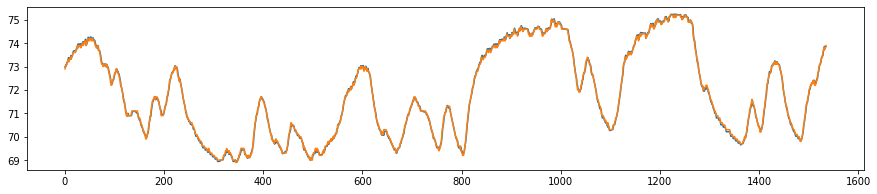

In [11]:
print("r2: ", r2_score(Tz_3, Tz_3_t))

plt.figure(figsize=(15, 3))
plt.plot(Tz_3_t.numpy())
plt.plot(Tz_3)
plt.show()